<a href="https://colab.research.google.com/github/atheendre130505/gans_monet/blob/main/CUT_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
# Set device to GPU if available, otherwise CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Path to the dataset on Kaggle
DATA_PATH = "/kaggle/input/gan-getting-started/"
MONET_PATH = os.path.join(DATA_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(DATA_PATH, "photo_jpg")

# Image and training settings
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1 # For CUT, a batch size of 1 is standard

print(f"Using device: {DEVICE}")
print(f"Monet images found: {len(os.listdir(MONET_PATH))}")
print(f"Photo images found: {len(os.listdir(PHOTO_PATH))}")

Using device: cpu
Monet images found: 300
Photo images found: 7038


In [ ]:
class ImageDataset(Dataset):
    """
    A custom dataset class to load images from a directory.
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Use glob to find all jpg files
        self.image_files = glob.glob(os.path.join(self.root_dir, "*.jpg"))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        img_path = self.image_files[idx]
        # Open the image using PIL
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# --- Transformations ---
# This is our data augmentation and preprocessing pipeline
# The values for mean and std are (0.5, 0.5, 0.5) to normalize images to [-1, 1]
transforms = T.Compose([
    T.Resize(int(IMG_HEIGHT * 1.12), T.InterpolationMode.BICUBIC),
    T.RandomCrop((IMG_HEIGHT, IMG_WIDTH)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- Create Datasets and DataLoaders ---
# Instantiate the datasets
monet_dataset = ImageDataset(root_dir=MONET_PATH, transform=transforms)
photo_dataset = ImageDataset(root_dir=PHOTO_PATH, transform=transforms)

# Create the DataLoaders
monet_loader = DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
photo_loader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Monet dataset size: {len(monet_dataset)}")
print(f"Photo dataset size: {len(photo_dataset)}")

Monet dataset size: 300
Photo dataset size: 7038


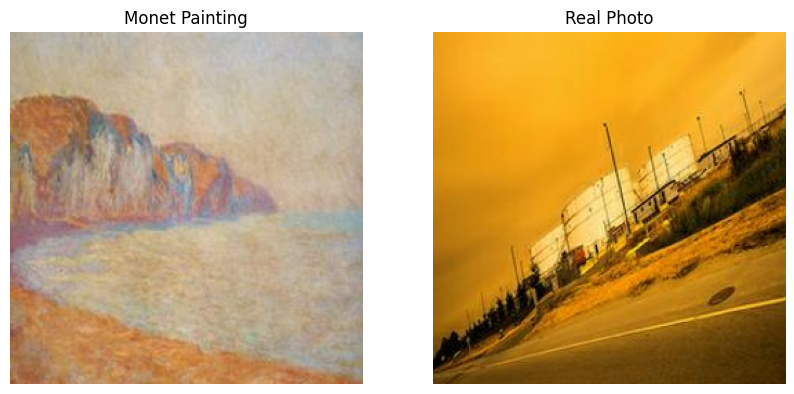

In [ ]:
def denormalize_img(img_tensor):
    """Denormalizes a tensor image from [-1, 1] to [0, 1] for visualization."""
    return img_tensor * 0.5 + 0.5

# Get one example from each loader
example_monet = next(iter(monet_loader))
example_photo = next(iter(photo_loader))

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display Monet painting
# We use permute(1, 2, 0) to change from (C, H, W) to (H, W, C) for matplotlib
ax[0].imshow(denormalize_img(example_monet[0]).permute(1, 2, 0))
ax[0].set_title("Monet Painting")
ax[0].axis("off")

# Display Photo
ax[1].imshow(denormalize_img(example_photo[0]).permute(1, 2, 0))
ax[1].set_title("Real Photo")
ax[1].axis("off")

plt.show()

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    A single residual block for the Generator.
    """
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        # The convolutional block
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Padding to keep size constant
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        # The output of the block is added to the input (the "residual" connection)
        return x + self.block(x)

In [ ]:
class Generator(nn.Module):
    """
    The ResNet-based generator, now modified to return intermediate features for PatchNCE loss.
    """
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=9):
        super(Generator, self).__init__()

        # --- Initial Convolution Block ---
        self.initial_block = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # --- Downsampling ---
        in_features = 64
        self.downsampling = []
        for i in range(2):
            out_features = in_features * 2
            self.downsampling.append(nn.Sequential(
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ))
            in_features = out_features
        self.downsampling = nn.ModuleList(self.downsampling)

        # --- Residual Blocks ---
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(in_features) for _ in range(n_residual_blocks)]
        )

        # --- Upsampling ---
        self.upsampling = []
        for i in range(2):
            out_features = in_features // 2
            self.upsampling.append(nn.Sequential(
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ))
            in_features = out_features
        self.upsampling = nn.ModuleList(self.upsampling)

        # --- Output Layer ---
        self.output_block = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        )

    def forward(self, x, extract_features=False):
        # The layers from which we'll extract features
        feature_layers = [0, 4, 8, 12, 16]

        # --- Encoder Path ---
        features = []
        x = self.initial_block(x)
        features.append(x)

        for layer in self.downsampling:
            x = layer(x)
            features.append(x)

        x = self.residual_blocks(x)
        features.append(x)

        if extract_features:
            # Return a list of feature maps from the specified layers
            return [features[i] for i in feature_layers]

        # --- Decoder Path ---
        for layer in self.upsampling:
            x = layer(x)

        output = self.output_block(x)
        return output

# --- Re-initialize the generator with our updated class ---
gen_photo_to_monet = Generator().to(DEVICE)
gen_photo_to_monet.apply(weights_init_normal)

# Re-chain the parameters for the optimizer
optimizer_G = torch.optim.Adam(
    chain(gen_photo_to_monet.parameters(), patch_nce_head.parameters()),
    lr=LR,
    betas=(BETA1, BETA2)
)

In [ ]:
class Discriminator(nn.Module):
    """
    The PatchGAN discriminator.
    """
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        # A series of Conv2d -> InstanceNorm2d -> LeakyReLU blocks
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_nc, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1) # Final output layer
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
class PatchNCEHead(nn.Module):
    """
    The projection head for the PatchNCE loss.
    This is a simple 2-layer MLP.
    """
    def __init__(self, in_c, proj_c=256):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_c, proj_c, 1),
            nn.ReLU(),
            nn.Conv2d(proj_c, proj_c, 1),
        )

    def forward(self, x):
        return self.proj(x)

In [ ]:
import torch.nn.functional as F

# --- Weight Initialization ---
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution with mean=0, std=0.02.
    """
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

# --- Instantiate Models ---
# Generator for Photo -> Monet
gen_photo_to_monet = Generator().to(DEVICE)
# Discriminator for Monet domain
disc_monet = Discriminator().to(DEVICE)
# The PatchNCE projection head
patch_nce_head = PatchNCEHead(in_c=256).to(DEVICE)

# Apply the weight initialization
gen_photo_to_monet.apply(weights_init_normal)
disc_monet.apply(weights_init_normal)
patch_nce_head.apply(weights_init_normal)

print("Models initialized and moved to device.")

Models initialized and moved to device.


In [ ]:
# --- GAN Loss (using Mean Squared Error) ---
# This measures how well the generator can fool the discriminator.
gan_loss_fn = nn.MSELoss()

# --- Identity Loss (using L1 Loss) ---
# This encourages the generator to not change images that are already in the target domain.
# For example, G(monet_image) should be very close to monet_image.
identity_loss_fn = nn.L1Loss()

class PatchNCELoss(nn.Module):
    """
    The main contrastive loss function for CUT.
    It calculates the cross-entropy loss between positive and negative patches.
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        # Use CrossEntropyLoss with logits, as we'll compute similarities (logits) manually
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction="none")

    def forward(self, feat_q, feat_k):
        # Normalize the features to be on the unit sphere
        feat_q = F.normalize(feat_q, p=2, dim=1)
        feat_k = F.normalize(feat_k, p=2, dim=1)

        # Calculate the similarity between the query and all keys (positive and negative)
        # feat_k.transpose(2, 3) makes it (B, C, W, H) to prepare for matrix multiplication
        # The result `l_all` will have shape (B, N, N) where N is num_patches
        l_all = torch.matmul(feat_q.transpose(1,3), feat_k.transpose(1,3).transpose(2,3))

        # The diagonal elements are the similarities between corresponding patches (positives)
        l_pos = torch.diagonal(l_all, dim1=-2, dim2=-1).view(l_all.shape[0], -1, 1)

        # The off-diagonal elements are the similarities with other patches (negatives)
        # We create a mask to select only the off-diagonal elements
        mask = ~torch.eye(l_all.shape[-1], device=l_all.device, dtype=torch.bool).unsqueeze(0)
        l_neg = l_all[mask].view(l_all.shape[0], -1, l_all.shape[-1] - 1)

        # Create the final logits tensor: [positive_similarity, negative_similarity_1, negative_similarity_2, ...]
        out = torch.cat((l_pos, l_neg), dim=2) / self.temperature

        # The target for cross-entropy is always the first element (the positive one)
        # So we create a tensor of zeros.
        targets = torch.zeros(out.size(0), out.size(1), dtype=torch.long, device=out.device)

        # Calculate the loss and return the mean over all patches and batches
        loss = self.cross_entropy_loss(out.transpose(1,2), targets)
        return loss.mean()

# Instantiate the PatchNCE loss
patch_nce_loss_fn = PatchNCELoss().to(DEVICE)

In [ ]:
from itertools import chain

# --- Hyperparameters ---
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999

# --- Create Optimizers ---
# The generator's optimizer updates both the generator and the PatchNCE head
optimizer_G = torch.optim.Adam(
    chain(gen_photo_to_monet.parameters(), patch_nce_head.parameters()),
    lr=LR,
    betas=(BETA1, BETA2)
)

# The discriminator's optimizer only updates the discriminator
optimizer_D = torch.optim.Adam(
    disc_monet.parameters(),
    lr=LR,
    betas=(BETA1, BETA2)
)

print("Optimizers created.")

Optimizers created.
